In [59]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import requests
import tqdm

In [60]:
def get_count(unix_time, lat_max, lat_min, lon_min, lon_max):
    """
    latitude and longtitude are to 3 decimal point precision
    not sure why the format ask for the time as unix_time + 60 and unix time but it seems to work
    """
    url = 'https://data-live.flightradar24.com/zones/fcgi/feed.js?faa=1&'
    url += 'bounds={:.3f}%2C{:.3f}%2C{:.3f}%2C{:.3f}'.format(lat_max, lat_min, lon_min, lon_max)
    url += '&satellite=1&mlat=1&flarm=1&adsb=1&gnd=1&air=1&vehicles=1&estimated=1%26maxage%3D14400&gliders=1&stats=1&'
    url += 'prefetch={:d}&history={:d}'.format(unix_time+60, unix_time)
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    d = r.json()
    if len(d.keys()) > 3:
        visible_flights = [d[key][1:3] for i, key in enumerate(d.keys()) if 1<i<len(d.keys())-1]
    else:
        vis = d['stats']['visible']['ads-b']
        visible_flights = vis
   # assert len(visible_flights) == d['stats']['visible']['ads-b']
    return visible_flights

In [61]:
R_earth = 6.378e3  # km
diagonal_length = 200 # km
side_length = diagonal_length / np.sqrt(2)  # for a square

lat_max = 39.3864
lon_max = -113.1708

x_max = R_earth * np.cos(lat_max*np.pi/180) * np.cos(lon_max*np.pi/180)  # at y_max
x_min = x_max - side_length  # at y_max
lon_min = np.arccos(x_min / (R_earth * np.cos(lat_max*np.pi/180))) * 180/np.pi
if lon_min > 0:
    lon_min *= -1  # since cos(-x) = cos(x), make sure to return the negative

y_max = R_earth * np.cos(lat_max*np.pi/180) * np.sin(lon_max*np.pi/180)  # at x_max
y_min = y_max - side_length  # at x_max
lat_min = np.arccos(y_min / (R_earth * np.sin(lon_max*np.pi/180))) * 180/np.pi

print(lat_min)
print(lon_min)
print(side_length)

37.15514037426772
-114.97118909325312
141.42135623730948


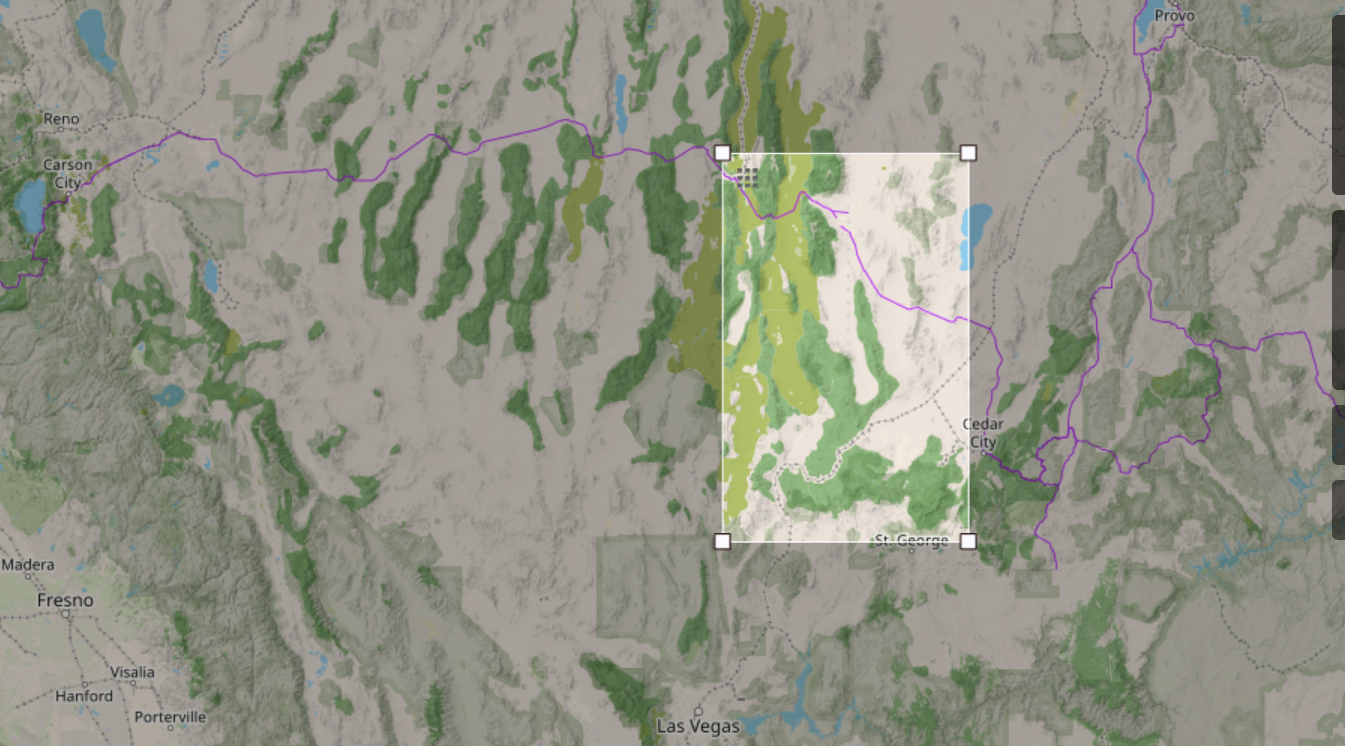

Flightradar24 makes data >7 days old unavailable for free users (confirmed on their website).

In [62]:
# get data every minute for a day, Oct 14 9:05 and a week back (in PDT, which is UTC-07:00)
seconds_per_week = 3600 * 24 * 7
time_start = int(datetime.datetime.now().timestamp()) - seconds_per_week  # in PDT, can confirm with datetime.dateime.now()
time_res = 30  # seconds
times = [time_start + i * time_res for i in range(seconds_per_week // time_res)]

In [96]:
for i, t in enumerate(tqdm.tqdm(times[len(flights):])):
    d = get_count(t, lat_max, lat_min, lon_min, lon_max)
    flights.append(d)

100%|██████████████████████████████████████████████████████████████████████████████| 3028/3028 [22:17<00:00,  2.26it/s]


In [97]:
flen = []
for f in flights:
    if f == 0:
        flen.append(f)
    else:
        flen.append(len(f))

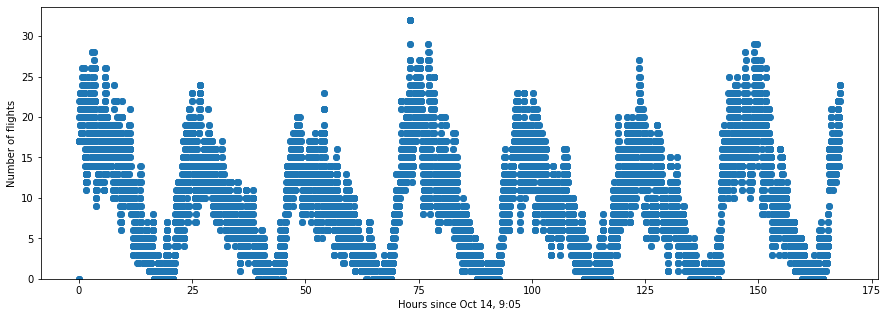

In [98]:
plt.figure(figsize=(15,5))
plt.scatter([(t-times[0])/3600 for t in times[:len(flen)]], flen)
plt.xlabel('Hours since Oct 14, 9:05')
plt.ylabel('Number of flights')
plt.ylim(0)
#plt.xlim(16, 26)
#plt.yticks([0, 1, 2, 3])
plt.show()

Let's bin together flights arriving in the same time interval at different days.

In [103]:
no_flights = np.empty((7, len(flen)//7))
for i in range(7):
    row = flen[i*len(flen)//7:(i+1)*len(flen)//7]  # day of data
    no_flights[i] = row

In [110]:
binned_flights = np.mean(no_flights, axis=0)
sd_dev = np.std(no_flights, axis=0)

In [150]:
start_time = datetime.datetime.fromtimestamp(times[0])
start_time_h = start_time.hour + start_time.minute/60 + start_time.second/3600
print(start_time_h)

9.075


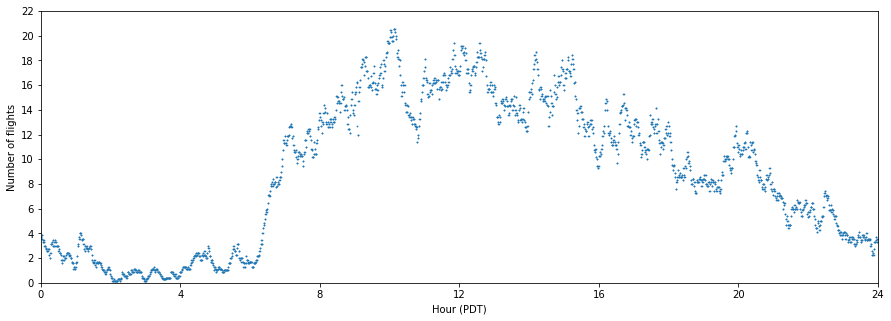

In [153]:
plt.figure(figsize=(15,5))
#plt.errorbar([(t-times[0])/3600 for t in times[:len(flen)//7]], binned_flights, yerr=sd_dev/np.sqrt(7), fmt='.')
plt.scatter((np.array([(t-times[0])/3600 for t in times[:len(flen)//7]])+start_time_h) % 24, binned_flights, s=0.5)
plt.xlabel('Hour (PDT)')
plt.ylabel('Number of flights')
plt.ylim(0)
plt.xlim(0, 24)
plt.xticks([0, 4, 8, 12, 16, 20, 24])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
plt.savefig('flights_marjum.png')
plt.show()

In [154]:
flight_indices = [i for i, x in enumerate(flen) if x>0]

In [155]:
len(flight_indices)/len(flights) * 100  # % time with a flight

92.27678571428571

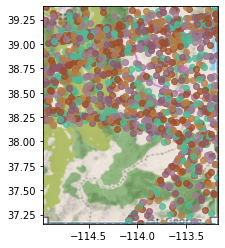

In [156]:
map_fig = plt.imread('bbox_for_planes4.png')
map_box = [lon_min, lon_max, lat_min, lat_max]
plt.figure()
plt.imshow(map_fig, extent=map_box)
for i in range(len(flight_indices)//7):
    plt.scatter(*flights[flight_indices[i]][0][::-1], alpha=0.5)
plt.axhline(lat_min, ls='--')
plt.axhline(lat_max, ls='--')
plt.axvline(lon_min, ls='--')
plt.axvline(lon_max, ls='--')
plt.savefig('flights_map_marjum.png')
plt.show()

In [157]:
np.save('flights.npy', flights, allow_pickle=True)

In [158]:
np.save('times.npy', times, allow_pickle=True)

In [133]:
f111 = np.load('flights.npy', allow_pickle=True)